In [49]:
%matplotlib inline
import warnings
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from dmba import regressionSummary
from sklearn.model_selection import train_test_split

In [50]:
df = pd.read_csv('Housing.csv')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0.00632  505 non-null    float64
 1   18       505 non-null    float64
 2   2.31     505 non-null    float64
 3   0        505 non-null    int64  
 4   0.538    505 non-null    float64
 5   6.575    505 non-null    float64
 6   65.2     505 non-null    float64
 7   4.09     505 non-null    float64
 8   1        505 non-null    int64  
 9   296      505 non-null    int64  
 10  15.3     505 non-null    float64
 11  396.9    505 non-null    float64
 12  4.98     505 non-null    float64
 13  24       505 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB


In [52]:
X = df.values[:,:-1]
y = df.values[:, -1]

In [53]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
class Linear_Regression:
    def __init__(self, X, y, max_iteration, epsilon, lambda_, learning_rate, sgd, gd=True, regularization=True, batch_size = None) -> None:
        self.X = X
        self.y = y
        self.max_iteration = max_iteration
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.learning_rate = learning_rate
        self.sgd = sgd
        self.gd = gd
        self.regularization = regularization
        self.batch_size = batch_size

    def split_data(self):
      X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                          self.y,
                                                          test_size=0.3,
                                                          shuffle= True)
      return X_train, X_test, y_train, y_test

    def add_X0(self, X):
      return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_train(self,X):
      mean = np.mean(X, axis = 0)
      std = np.std(X, axis = 0)
      X = (X - mean) / std
      X = self.add_X0(X)
      return X, mean, std

    def normalize_test(self, X, mean, std):
      X = (X - mean) / std
      X = self.add_X0(X)
      return X

    def rank(self, X):
      u, s, v = np.linalg.svd(X)
      return len([x for x in s if x > 0.0005])

    def check_fullRank(self,X):
      rank = self.rank(X)
      if rank == min(X.shape):
        self.full_rank = True
        print("it is full rank")
      else:
        self.full_rank = False
        print("it is not full rank")

    def check_lowRank(self, X):
      if X.shape[0] < X.shape[1]:
        self.low_rank = True
        print("it is low rank")
      else:
        self.low_rank = False
        print("it is not low rank")

    def closed_form_solution(self, X, y):
    #Adding the penalty term as L2 Norm
      if self.regularization == True:
        self.theta = np.linalg.inv(X.T.dot(X) + self.lambda_ * np.identity(X.shape[1])).dot(X.T).dot(y)
      else:
        self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

      return self.theta

    def predict(self, X):
      return X.dot(self.theta)
    
    def sse(self, X, y):
      y_hat = self.predict(X)
      return ((y_hat - y) ** 2).sum()
    
    def calculate_me(self, y_true, y_pred):
      return np.mean(y_true - y_pred)

    def calculate_rmse(self, y_true, y_pred):
      return np.sqrt(np.mean((y_true - y_pred) ** 2))

    def calculate_mae(self, y_true, y_pred):
      return np.mean(np.abs(y_true - y_pred))

    def calculate_mpe(self, y_true, y_pred):
      return np.mean((y_true - y_pred) / y_true) * 100

    def calculate_mape(self, y_true, y_pred):
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def cost_function(self, X, y):
      loss = self.sse(X, y)
      return loss / 2
    
    def cost_derivative(self, X, y):
      if self.regularization == 'ridge':
        y_hat = self.predict(X)
        return (X.T.dot(y_hat - y) + self.lambda_ * self.theta)
      elif self.regularization == 'lasso':
        y_hat = self.predict(X)
        return (X.T.dot(y_hat - y)+ np.sign(self.theta))
      else:
        y_hat = self.predict(X)
        return X.T.dot(y_hat - y)

    def gradient_descent(self, X, y):
      errors = []
      prev_error = float("inf")

      for t in tqdm(range(self.max_iteration), colour = 'blue'):
        self.theta -= self.learning_rate * self.cost_derivative(X, y)
        error = self.cost_function(X, y)
        errors.append(error)

        if abs(error - prev_error) < self.epsilon:
          print("Model stopped learning")
          break

      self.plot_rmse(errors)    
      
    def stocastic_gradient_descent(self, X, y):
      errors = []
      prev_error = float("inf")
      
      print("Batch size: " + str(int(len(y) * self.batch_size)))
      
      self.slice_rowsX = int(X.shape[0] * self.batch_size)
      self.slice_rowsy = int(len(y) * self.batch_size)
      
      #slice X till batch_size
      sgdX = X[:self.slice_rowsX, :]
      sgdy = y[:self.slice_rowsy]

      for t in tqdm(range(self.max_iteration), colour = 'blue'):
        self.theta -= self.learning_rate * self.cost_derivative(sgdX, sgdy)
        error = self.cost_function(sgdX, sgdy)
        errors.append(error)

        if abs(error - prev_error) < self.epsilon:
          print("Model stopped learning")
          break

      self.plot_rmse(errors)

    def plot_prediction_comparison(self, y_true, y_pred):
      """
      Plot a line chart comparing true values (y_true) and predicted values (y_pred).
      """
      days = np.arange(len(y_true))  # Assuming one count per day
      
      plt.figure(figsize=(8, 6))
      plt.plot(days, y_true, color='black', label='True Values')
      plt.plot(days, y_pred, color='orange', label='Predicted Values')
      plt.xlabel('Days')
      plt.ylabel('Counts')
      plt.title('True Values vs. Predicted Values')
      plt.legend()
      plt.grid(True)
      plt.show()
    
    def fit(self):
      X_train, X_test, y_train, y_test = self.split_data()
      X_train, mean, std = self. normalize_train(X_train)
      X_test = self.normalize_test(X_test, mean, std)
      self.check_fullRank(X_train)
      self.check_lowRank(X_train)

      if self.full_rank and not self.low_rank and X_train.shape[1] < 1000 and not self.gd and not self.sgd:
          print("Closed form solution")
          self.closed_form_solution(X_train, y_train)
      elif self.gd or self.low_rank:
        print("Gradient Descent")
        self.theta = np.ones(X_train.shape[1])
        self.gradient_descent (X_train, y_train)
      else:
        print("Stochastic Gradient Descent")
        self.theta = np.ones(X_train.shape[1])
        self.stocastic_gradient_descent(X_train, y_train)

      y_pred = self.predict(X_test)
      print('Thetas: ', self.theta)
      print("Predicted values:", y_pred)
      print("True values:", y_test)
      self.plot_prediction_comparison(y_test, y_pred)
      
      rmse = self.calculate_rmse(y_test, y_pred)
      mae = self.calculate_mae(y_test, y_pred)
      me = self.calculate_me(y_test, y_pred)
      mpe = self.calculate_mpe(y_test, y_pred)
      mape = self.calculate_mape(y_test, y_pred)

      print("Mean Error (ME):", me)
      print("Root Mean Squared Error (RMSE):", rmse)
      print("Mean Absolute Error (MAE):", mae)
      print("Mean Percentage Error (MPE):", mpe)
      print("Mean Absolute Percentage Error (MAPE):", mape)


    def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel=list(range(len(error_sequence))))
        ax.grid()

        plt.legend(["Error Curve"], bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()


it is full rank
it is not low rank
Closed form solution
Thetas:  [ 2.27007733e+01 -9.49457956e-01  8.57724442e-01  1.78982779e-01
  5.47473469e-01 -1.63909582e+00  3.28751397e+00  9.81193653e-03
 -2.67872455e+00  2.44802072e+00 -2.02334590e+00 -2.15561516e+00
  7.84154644e-01 -3.57082251e+00]
Predicted values: [24.96088505 30.53055512 19.23023001 31.06527363 30.36432082 33.12177901
 17.67308763 15.93221508 22.55678391 18.02248895 42.26207104 19.32607353
 32.41535893 24.26021889 22.73204633 21.77645078 15.78857474 24.78326326
 13.60091833 16.68678462 23.6290656  21.57709743 21.83510317 35.97898395
 21.76099268 14.33636571 19.72087979 20.29908069 17.87805632 20.81194512
 17.27096084 28.86454633 25.77960325 10.83360334 23.03611015 25.28209871
 12.84903382 22.77431192 13.10246427 35.35082641 26.90028041 28.83093003
 20.9224539  22.6199577   8.70256248 10.81853185 20.89154749 19.83377141
 25.30010362 29.93220735 25.32526623 12.69473412 19.72081214 33.06790433
 38.12102432 28.84106406 17.121

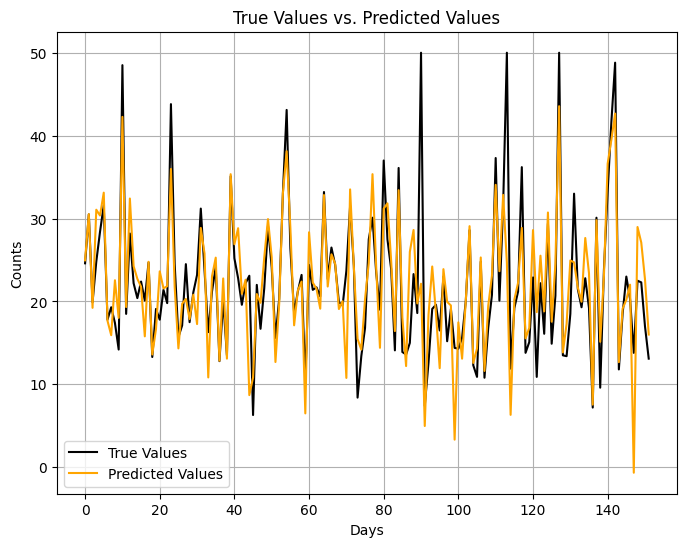

Mean Error (ME): -0.018480211102206094
Root Mean Squared Error (RMSE): 5.050107814023117
Mean Absolute Error (MAE): 3.250353292360901
Mean Percentage Error (MPE): -3.0614690944407266
Mean Absolute Percentage Error (MAPE): 16.31135494058244


In [55]:
# Closed form solution 
# Regularization = True

lr = Linear_Regression(X, y, max_iteration=50, epsilon=0.003, learning_rate=0.001, lambda_ = 0.01,
                      sgd = False, 
                      gd = False, 
                      regularization=True)
lr.fit()


In [56]:
# # Closed form solution 
# Regularization = False

# lr = Linear_Regression(X, y, max_iteration=50, epsilon=0.003, learning_rate=0.001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = False, 
#                       regularization=False)
# lr.fit()

In [57]:
# # Gradient Descent 
# # Regularization = lasso
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = True, 
#                       regularization='lasso')
# lr.fit()

In [58]:
# # Gradient Descent 
# # Regularization = ridge
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = True, 
#                       regularization='ridge')
# lr.fit()

In [59]:
# Gradient Descent 
# Regularization = Fasle
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = True, 
#                       regularization=False)

# lr.fit()

In [60]:
# Stocastic Gradient Descent 
# Regularization = True
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       batch_size=0.3,
#                       sgd = True, 
#                       gd = False, 
#                       regularization=True)

# lr.fit()

In [61]:
# Stocastic Gradient Descent 
# Regularization = False
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       batch_size=0.3,
#                       sgd = True, 
#                       gd = False, 
#                       regularization=False)

# lr.fit()